<a href="https://colab.research.google.com/github/adallak/FAST2022_ExplainableAI/blob/main/Session2_ModelAgnostic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tabular data

We start our exploration with tabular data using the dataset we used last time

In [49]:
#Setup
!pip install eli5 
!pip install scikit-learn==0.24
# Download files
!rm -f bank-additional-full.csv*
!wget https://raw.githubusercontent.com/adallak/FAST2022_ExplainableAI/main/data/bank-additional-full.csv


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 2.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.20.0
    Uninstalling scikit-learn-0.20.0:
      Successfully uninstalled scikit-learn-0.20.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.0 which is incompatible.


--2022-06-24 13:48:58--  https://raw.githubusercontent.com/adallak/FAST2022_ExplainableAI/main/data/bank-additional-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5834924 (5.6M) [text/plain]
Saving to: ‘bank-additional-full.csv’

bank-additional-ful 100%[===================>]   5.56M  --.-KB/s    in 0.08s   

2022-06-24 13:48:58 (71.0 MB/s) - ‘bank-additional-full.csv’ saved [5834924/5834924]



In [2]:
# Obviously
import pandas as pd

# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from xgboost.sklearn import XGBClassifier

###The Dataset



The dataset can be downloaded here. It consists of data from marketing campaigns of a Portuguese bank. We will try to build classifiers that can predict whether or not the client targeted by the campaign ended up subscribing to a term deposit (column y).

In [3]:
df = pd.read_csv("bank-additional-full.csv", sep=";")
df.y.value_counts()

## Get X, y
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)


Let's look at the features in the X matrix:

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

In [4]:
X.drop("duration", inplace=True, axis=1)
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

In [5]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [6]:
# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      # Add a scale_pos_weight to make it balanced
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1499: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:1499: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

### LIME implementation

 LIME creates a dataset in the locality of our observation by perturbating the different features. Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

In [8]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:639: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_folds = np.zeros(n_samples, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:437: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [5, 10], 'model__min_child_weight': [5, 10], 'model__n_estimators': [25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [9]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.9002115778155457


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))])

`Important` Given the best parameters, would you do any additional steps?

In [10]:
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

In [11]:
accuracy_score(y_test, y_pred)

0.9014323865015781

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.71      0.21      0.32      1392

   micro avg       0.90      0.90      0.90     12357
   macro avg       0.81      0.60      0.64     12357
weighted avg       0.89      0.90      0.88     12357



In [13]:
import eli5
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
all_features = num_features + new_ohe_features


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
/usr/

####Create an explainer


In order to explain why the model classifies invidividual observations as class 0 or 1, we are going to use the `LimeTabularExplainer` from the library `lime`, this is the main explainer to use for tabular data. Lime also provides an explainer for text data, for images and for time-series.

When using the tabular explainer, we need to provide our training set as parameter so that `lime` can compute statistics on each feature, either `mean` and `std` for numerical features, or frequency of values for categorical features. Those statistics are used to scale the data and generate new perturbated data to train our local linear models on.

We use these computed statistics for two things:

    1. To scale the data, so that we can meaningfully compute distances when the attributes are not on the same scale

    2. To sample perturbed instances - which we do by sampling from a Normal(0,1), multiplying by the std and adding back the mean.



In [14]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 5.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=eb23b84f7e7418e29dd85226c2a788e9df5851412743aaaa4738a61576e8c5df
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


The parameters passed to the explainer are:
- our training set, we need to make sure we use the training set *without* one hot encoding
- `mode`: the explainer can be used for classification or regression
- `feature_names`: list of labels for our features
- `categorical_features`: list of indexes of categorical features
- `categorical_names`: dict mapping each index of categorical feature to a list of corresponding labels
- `dicretize_continuous`: will discretize numerical values into buckets that can be used for explanation. For instance it can tell us that the decision was made because distance is in bucket [5km, 10km] instead of telling us distance is an importante feature.

First, in order to get the `categorical_names` parameter we need to build a dictionary with indexes of categorical values in original dataset as keys and lists of possible categories as values:

In [15]:
categorical_names = {}
for col in cat_features:
    categorical_names[X_train.columns.get_loc(col)] = [new_col.split("__")[1] 
                                                       for new_col in new_ohe_features 
                                                       if new_col.split("__")[0] == col]

In [16]:
categorical_names

{1: ['admin.',
  'blue-collar',
  'entrepreneur',
  'housemaid',
  'management',
  'retired',
  'self-employed',
  'services',
  'student',
  'technician',
  'unemployed',
  'unknown'],
 2: ['divorced', 'married', 'single', 'unknown'],
 3: ['basic.4y',
  'basic.6y',
  'basic.9y',
  'high.school',
  'illiterate',
  'professional.course',
  'university.degree',
  'unknown'],
 4: ['no', 'unknown', 'yes'],
 5: ['no', 'unknown', 'yes'],
 6: ['no', 'unknown', 'yes'],
 7: ['cellular', 'telephone'],
 8: ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'],
 9: ['fri', 'mon', 'thu', 'tue', 'wed'],
 13: ['failure', 'nonexistent', 'success']}

`Lime` needs the dataset that is passed to have categorical values converted to integer labels that maps to the values in `categorical_names`. For instance, label `0` for the column `2` will map to `divorced`. We will use a custom helper function to do so, that converts data from original to LIME and from LIME to original format.

That function below goes over all categorical features and replaces strings by the correct integer labels.

In [17]:
import pandas as pd


def convert_to_lime_format(X, categorical_names, col_names=None, invert=False):
    """Converts data with categorical values as string into the right format 
    for LIME, with categorical values as integers labels.
    It takes categorical_names, the same dictionary that has to be passed
    to LIME to ensure consistency. 
    col_names and invert allow to rebuild the original dataFrame from
    a numpy array in LIME format to be passed to a Pipeline or sklearn
    OneHotEncoder
    """

    # If the data isn't a dataframe, we need to be able to build it
    if not isinstance(X, pd.DataFrame):
        X_lime = pd.DataFrame(X, columns=col_names)
    else:
        X_lime = X.copy()

    for k, v in categorical_names.items():
        if not invert:
            label_map = {
                str_label: int_label for int_label, str_label in enumerate(v)
            }
        else:
            label_map = {
                int_label: str_label for int_label, str_label in enumerate(v)
            }

        X_lime.iloc[:, k] = X_lime.iloc[:, k].map(label_map)

    return X_lime

In [18]:
convert_to_lime_format(X_train, categorical_names).head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
7309,50,1,2,0,0,0,0,1,6,2,2,999,0,1,1.1,93.994,-36.4,4.860,5191.0
4169,51,7,1,5,1,0,0,1,6,1,5,999,0,1,1.1,93.994,-36.4,4.858,5191.0
35810,46,9,0,5,0,2,0,0,6,1,2,999,0,1,-1.8,92.893,-46.2,1.244,5099.1
9668,46,0,2,6,0,2,0,1,4,1,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
34389,25,7,2,3,0,0,0,0,6,2,5,999,0,1,-1.8,92.893,-46.2,1.266,5099.1


In [19]:
explainer = LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns.tolist(),
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 discretize_continuous=True,
                                 random_state=42)

Now, lets choose one observation and try to explain it. 

In [20]:
i = 5
X_observation = X_test.iloc[[i], :]
X_observation

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
11742,33,technician,single,professional.course,no,no,yes,telephone,jun,fri,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1


In [21]:
print(f"""\
* True label: {y_test.iloc[i]}
* XGB: {xgb_model.predict_proba(X_observation)[0]}""")

* True label: 0
* XGB: [0.9292013  0.07079868]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

Let's convert our observation to lime format and convert it to a numpy array.

In [22]:
observation = convert_to_lime_format(X_test.iloc[[i], :],categorical_names).values[0]
observation

array([ 3.3000e+01,  9.0000e+00,  2.0000e+00,  5.0000e+00,  0.0000e+00,
        0.0000e+00,  2.0000e+00,  1.0000e+00,  4.0000e+00,  0.0000e+00,
        3.0000e+00,  9.9900e+02,  0.0000e+00,  1.0000e+00,  1.4000e+00,
        9.4465e+01, -4.1800e+01,  4.9590e+00,  5.2281e+03])

In order to explain a prediction, we use the `explain_instance` method on our explainer. Recall that LIME works as follows: it generates new data with perturbated features around the observation and learns a local linear model. It needs to take:
- our observation as a numpy array
- a function that uses our model to predict probabilities given the data (in same format we've passed in our explainer). That means we cannot pass directly our `xgb_model.predict_proba` because our pipeline expects string labels for categorical values. We will need to create a custom function `xgb_predict_proba` that first converts back integer labels to strings and then calls `xgb_model.predict_proba`.
- `num_features`: number of features to consider in explanation

In [23]:
# Let write a custom predict_proba functions for our models:
from functools import partial

def custom_predict_proba(X, model):
    X_str = convert_to_lime_format(X, categorical_names, col_names=X_train.columns, invert=True)
    return model.predict_proba(X_str)

xgb_predict_proba = partial(custom_predict_proba, model=xgb_model)

The `partial()` is used for partial function application which “freezes” some portion of a function’s arguments resulting in a new object with a simplified signature. Here, `partial()` can be used to create a callable that behaves like the `custom_predict_proba()` function where the X is fixed.

In [24]:
explanation = explainer.explain_instance(observation, xgb_predict_proba,
                                         num_features=5)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/relea

Now that we have generated our explanation, we have access to several representations. The most useful one when working in a notebook is `show_in_notebook`.


On the left it shows the list of probabilities for each class, here the model classified our observation as 0 (non subsribed) with a high probability.
* If you set `show_table=True`, you will see the table with the most important features for this observation on the right.

In [25]:
explanation.show_in_notebook(show_table=True, show_all=False)

LIME is fitting a linear model on a local perturbated dataset. You can access the coefficients, the intercept and the R squared of the linear model by calling respectively `.local_exp`, `.intercept` and `.score` on your explanation.

In [26]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(18, -0.10882307033650553), (7, -0.06377444537385785), (17, -0.022080655992362117), (12, 0.012361805499771531), (16, -0.01073843311999782)]}
{1: 0.25344077568107454}
0.2647519167165805


If your R-squared is low, the linear model that LIME fitted isn't a great approximation to your model, which means you should not rely too much on the explanation it provides.

### SHAP Implementation

In [27]:
!pip install shap==0.24
import shap
# Need to load JS vis in the notebook
shap.initjs() 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 4.5 MB/s 
  Created wheel for shap: filename=shap-0.24.0-cp37-cp37m-linux_x86_64.whl size=231566 sha256=682958394f2b13e49db629fab3216dfb2e84b775012ad101a134c4e6ee656e0a
  Stored in directory: /root/.cache/pip/wheels/18/d7/4a/814dcd12f285ff5a2ac3a597af54196fd59dbe871423b5d5af
Successfully built shap


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/online_lda.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


SHAP has a generic explainer that works for any model and a TreeExplainer optimised for tree based models. Here we will focus on the `TreeExplainer` with our Random Forest model.

In [28]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

In order to compute the shapley values with the tree explainer, we need to call the `shap_values` methods passing a dataset. That can be quite computationally expensive, so we will only pass 1000 samples picked at random.

In [29]:
observations = xgb_model.named_steps["preprocessor"].transform(X_train.sample(1000, random_state=42))
observations= observations.astype(int)
shap_values = explainer.shap_values(observations)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:97: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros_like(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https:/

Now we can start visualising our explanations using the `force_plot` function from the shap package passing our first shap_value (we also need to pass `explainer.expected_value` which is the base value).

This explanation shows how each feature contributes to shifting the prediction from the base value to the output value of the model either by decreasing or increasing the probability of our class.

In [30]:
shap.initjs() 
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

In [31]:
shap_values[i]

array([-5.2330573e-03,  2.6761826e-02, -3.1810179e-02, -1.8274933e-03,
        2.1219118e-02,  3.3462845e-02,  2.2021720e-02,  3.9468732e-01,
       -2.0720607e-01,  0.0000000e+00, -1.3796329e-03, -2.5695543e-05,
        0.0000000e+00,  0.0000000e+00, -6.8895577e-04,  1.4266757e-04,
        9.1117217e-05,  0.0000000e+00, -8.4026984e-04,  0.0000000e+00,
        0.0000000e+00, -2.2180440e-04,  1.9019785e-04,  9.4016909e-04,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  4.1462618e-04,
        0.0000000e+00,  0.0000000e+00, -5.2849347e-05, -1.7171316e-03,
        0.0000000e+00,  1.6327631e-03,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  6.9985609e-03,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  2.9832348e-02,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -6.5895100e-04,
       -1.3115426e-04,  3.5049517e-05,  0.0000000e+00, -2.0956033e-04,
       -4.8241219e-03,  0.0000000e+00, -6.9881331e-05,  3.0067912e-03,
      

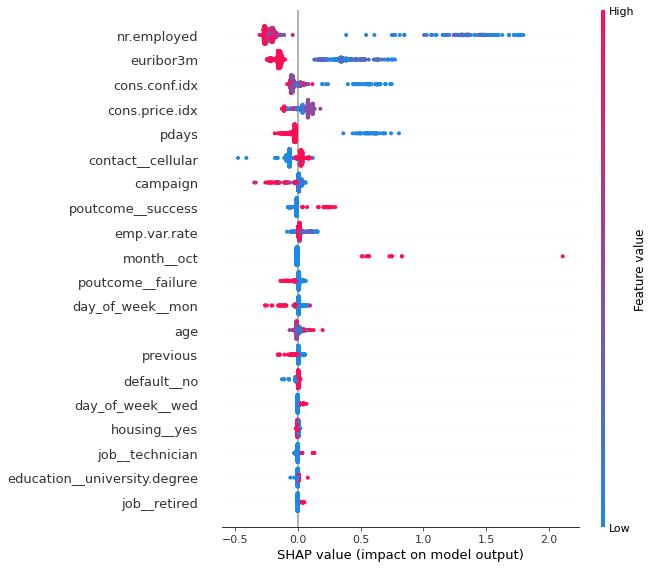

In [32]:
shap.initjs() 
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

In [33]:
list(all_features)

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job__admin.',
 'job__blue-collar',
 'job__entrepreneur',
 'job__housemaid',
 'job__management',
 'job__retired',
 'job__self-employed',
 'job__services',
 'job__student',
 'job__technician',
 'job__unemployed',
 'job__unknown',
 'marital__divorced',
 'marital__married',
 'marital__single',
 'marital__unknown',
 'education__basic.4y',
 'education__basic.6y',
 'education__basic.9y',
 'education__high.school',
 'education__illiterate',
 'education__professional.course',
 'education__university.degree',
 'education__unknown',
 'default__no',
 'default__unknown',
 'default__yes',
 'housing__no',
 'housing__unknown',
 'housing__yes',
 'loan__no',
 'loan__unknown',
 'loan__yes',
 'contact__cellular',
 'contact__telephone',
 'month__apr',
 'month__aug',
 'month__dec',
 'month__jul',
 'month__jun',
 'month__mar',
 'month__may',
 'month__nov',
 'month__oct',
 'month__sep',
 'day_of_week__fri',
 'day_of_week__mon',
 'day_of_week__thu',
 'day_of_week__tue',
 'day_of_week__wed',
 'poutcome__failure',
 'poutcome__nonexistent',
 'poutcome__success']

## LIME for the image data

In [34]:
from tensorflow import keras
from keras import layers
import numpy as np

In [35]:
model = keras.applications.xception.Xception(weights = "imagenet")

91897856/91884032 [==============================] - 1s 0us/step


In [36]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [37]:
import numpy as np
import os
fullPath = os.path.abspath("./" + "Yellow-Lab-High-Five.jpg")
img_path = keras.utils.get_file(
    fname="Yellow-Lab-High-Five.jpg",
    origin = "https://raw.githubusercontent.com/adallak/FAST2022_ExplainableAI/main/data/Yellow-Lab-High-Five.jpg") #"file://" + fullPath)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

81920/68191 [====================================] - 0s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


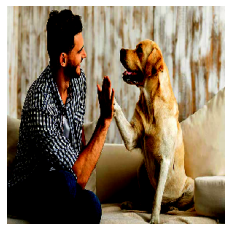

In [38]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_array[0])
plt.show()

In [39]:
preds = model.predict(img_array)

In [40]:
print(keras.applications.xception.decode_predictions(preds, top = 5)[0])

49152/35363 [=========================================] - 0s 0us/step
[('n02099712', 'Labrador_retriever', 0.79988563), ('n02099601', 'golden_retriever', 0.048275884), ('n02088466', 'bloodhound', 0.013911711), ('n02087394', 'Rhodesian_ridgeback', 0.006400207), ('n02115641', 'dingo', 0.006181965)]


Remember that LIME needs the indices of the class we are interested in. Execute the cell bellow to get the indices corresponding to the 5 most probably classes we predicted above. Those indices correspond to the classes used in the ImageNet dataset that was used to train our model.

In [41]:
model.predict(img_array).argsort()[0, -5:][::-1]

array([208, 207, 163, 159, 273])

Here the Labrador_retriever corresponds to index 208, the golden retriever to index 207, etc..

Let's get started. First import the `LimeImageExplainer` and instantiate a new explainer

In [42]:
!pip install lime
import lime
from lime.lime_image import LimeImageExplainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
explainer = LimeImageExplainer()

The explainer is the same as before, we call `explain_instance` to generate a new explanation. We need to provide:

-  our observation: here the first row of our numpy matrix (that has only one row since we only have one image)
- our predict function, we can simply use the one from our model here
- *top_labels* the number of classes to explain. Here our model generate probabilities for more than a 1000 classes (and we looked at the five first). We do not want LIME to generate local models to explain each of those classes. As lime is pretty slow with images, let's only ask for the explanation to our two main classes, labrador and golden retriever
- *num_samples*: the number of new datapoints to create to fit a linear model, let's set it to 1000

*WARNING*: that will be slow.

In [44]:
import numpy as np
explanation = explainer.explain_instance(img_array[0].astype(np.double), model.predict, 
                                         top_labels=2, num_samples=100,
                                         random_seed=42)

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


In [45]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

First let's check the explanation for the predicted class `labrador retriever`. That corresponds to label 208 in the ImageNet classes. We need to use the method `get_image_and_mask` on our explanation object with the following parameters:
- index of the class to explain. We'll start with the index of the main class predicted, that was 208
- positive_only: in order to show the part of the image that contribute positively to this class being selected
- num_features: number of superpixels to use. LIME breaks down our image into a set of superpixels, each containing several pixels. Those superpixels are equivalent to `features` in tabular data.
- hide_rest: to hide the rest of the image

That returns a new image and a mask as numpy arrays. You can then use `mark_boundaries` to show the image together with the mask.

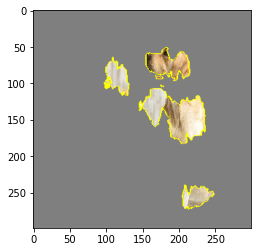

In [46]:
temp, mask = explanation.get_image_and_mask(208, positive_only=True, num_features=6, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

What feature do you expect to be the most important in that decision? Plot the image with only the main feature (`num_features=1`)

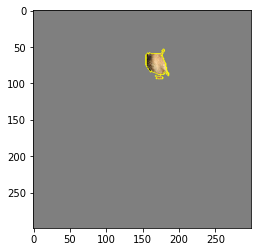

In [47]:
temp, mask = explanation.get_image_and_mask(208, positive_only=True, num_features=1, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

The second class predicted by our model was a golden retriever (label 207), set `positive_only=False` in order to see what features contributed positively and negatively to that decision. What do you see?

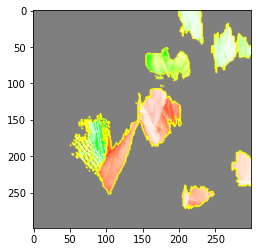

In [48]:
temp, mask = explanation.get_image_and_mask(207, positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Great, now you can try to change the number of features you're looking at and deactivate `positive_only` in order to see features that contribute negatively to the class. You can also look at other classes or try other pictures.